Importare le librerie


In [ ]:
!pip install timm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import timm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import drive
from PIL import Image

# Montare Google Drive
drive.mount('/content/drive')

# Configurazione dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Caricare i dati

In [4]:
# Percorsi dati
train_dir = '/content/drive/MyDrive/Night_Wolves/RPvsControl/data/train'
test_dir  = '/content/drive/MyDrive/Night_Wolves/RPvsControl/data/test'

# Trasformazioni per EfficientNet: dimensione 224x224
common_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

augmentation_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Dataset personalizzato per bilanciare retinite
class AugmentedImageFolder(torch.utils.data.Dataset):
    def __init__(self, root, common_transform, augmentation_transform, minority_class=1, replicate_factor=4):
        self.dataset = ImageFolder(root, transform=common_transform)
        self.common_transform = common_transform
        self.augmentation_transform = augmentation_transform
        self.minority_class = minority_class
        self.replicate_factor = replicate_factor

        # Aggiungi l'attributo classes
        self.classes = self.dataset.classes

        self.control_indices = [i for i, (_, label) in enumerate(self.dataset.samples) if label != self.minority_class]
        self.minority_indices = [i for i, (_, label) in enumerate(self.dataset.samples) if label == self.minority_class]
        self.rep_minority_indices = self.minority_indices * replicate_factor

        self.total_indices = self.control_indices + self.rep_minority_indices

    def __len__(self):
        return len(self.total_indices)

    def __getitem__(self, idx):
        real_idx = self.total_indices[idx]
        path, label = self.dataset.samples[real_idx]
        image = Image.open(path).convert('RGB')
        if label == self.minority_class:
            img = self.augmentation_transform(image)
        else:
            img = self.common_transform(image)
        return img, label

# Creazione del dataset bilanciato per training e dataset di test (senza augmentation)
full_train_data = AugmentedImageFolder(train_dir, common_transform, augmentation_transform, minority_class=1, replicate_factor=4)
test_data = ImageFolder(test_dir, transform=common_transform)
print(f"Training bilanciato: {len(full_train_data)} immagini; Test: {len(test_data)} immagini")

# Split training/validation 80/20
val_size = int(0.2 * len(full_train_data))
train_size = len(full_train_data) - val_size

# DataLoader per il test
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Classi
class_names = full_train_data.classes
print("Classi:", class_names)

Training bilanciato: 1632 immagini; Test: 258 immagini
Classi: ['control', 'retinite']


# Definizione della CNN

In [5]:
# Creazione del modello EfficientNet (efficientnet_b0)
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=1)
model = model.to(device)
print(model)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

# Funzione di perdita e ottimizzazione

In [6]:
# Loss, ottimizzatore e scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Addestrare il modello

Epoch 1/20 | Train Loss: 0.2644, Acc: 0.9640 | Val Loss: 0.0078, Acc: 0.9969
Epoch 2/20 | Train Loss: 0.0271, Acc: 0.9923 | Val Loss: 0.0067, Acc: 0.9969
Epoch 3/20 | Train Loss: 0.0758, Acc: 0.9870 | Val Loss: 0.0095, Acc: 0.9969
Epoch 4/20 | Train Loss: 0.0214, Acc: 0.9946 | Val Loss: 0.0013, Acc: 1.0000
Epoch 5/20 | Train Loss: 0.0127, Acc: 0.9954 | Val Loss: 0.0014, Acc: 1.0000
Epoch 6/20 | Train Loss: 0.0014, Acc: 1.0000 | Val Loss: 0.0000, Acc: 1.0000
Epoch 7/20 | Train Loss: 0.0083, Acc: 0.9962 | Val Loss: 0.0006, Acc: 1.0000
Epoch 8/20 | Train Loss: 0.0043, Acc: 0.9977 | Val Loss: 0.0244, Acc: 0.9939
Epoch 9/20 | Train Loss: 0.0129, Acc: 0.9962 | Val Loss: 0.0003, Acc: 1.0000
Epoch 10/20 | Train Loss: 0.0006, Acc: 1.0000 | Val Loss: 0.0000, Acc: 1.0000
Epoch 11/20 | Train Loss: 0.0067, Acc: 0.9985 | Val Loss: 0.0140, Acc: 0.9969
Epoch 12/20 | Train Loss: 0.0214, Acc: 0.9977 | Val Loss: 0.0091, Acc: 0.9969
Epoch 13/20 | Train Loss: 0.0212, Acc: 0.9954 | Val Loss: 0.0291, Acc: 0.

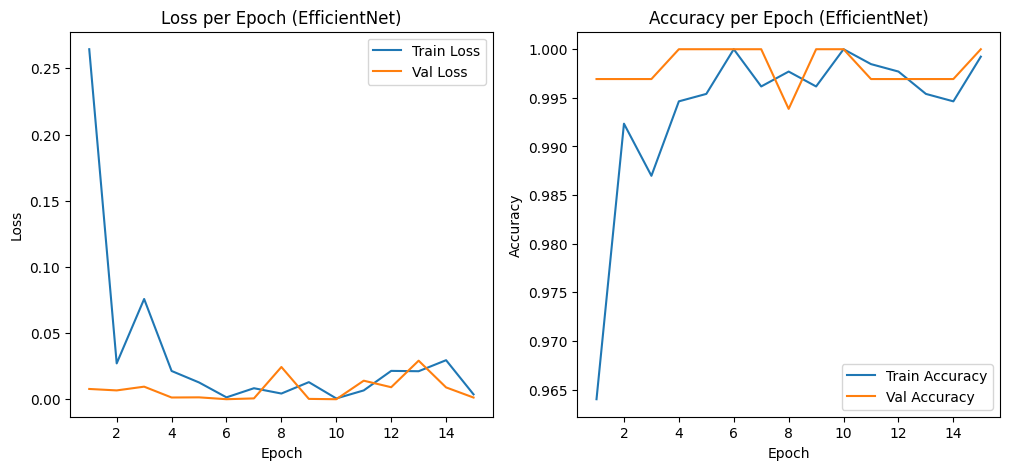

In [7]:
# Tracciamento metriche
num_epochs = 20
train_losses, val_losses = [], []
train_accs, val_accs = [], []
best_val_loss = float('inf')
patience, trigger_times = 5, 0

# Ciclo di addestramento con random split ad ogni epoca
for epoch in range(num_epochs):
    train_subset, val_subset = random_split(full_train_data, [train_size, val_size])
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader   = DataLoader(val_subset, batch_size=32, shuffle=True)

    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / total_train
    train_acc = correct_train / total_train
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validazione
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_val_loss / total_val
    val_acc = correct_val / total_val
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'efficientnet_best.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break

# Grafici di addestramento
epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch (EfficientNet)')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, train_accs, label='Train Accuracy')
plt.plot(epochs_range, val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch (EfficientNet)')
plt.legend()
plt.show()

# Valutazione del modello

In [8]:
# Funzione per valutare il modello
def evaluate(model, test_loader):
    model.eval()  # Imposta il modello in modalità di valutazione
    correct = 0
    total = 0

    with torch.no_grad():  # Disabilita il calcolo dei gradienti durante la valutazione
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = (outputs.squeeze() > 0.5).float()  # Predizione (0 o 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy}%")

# Valutazione del modello sui dati di test
evaluate(model, test_loader)

Accuracy: 94.18604651162791%


# Matrice di confusione

Confusion Matrix:
[[209   0]
 [ 15  34]]


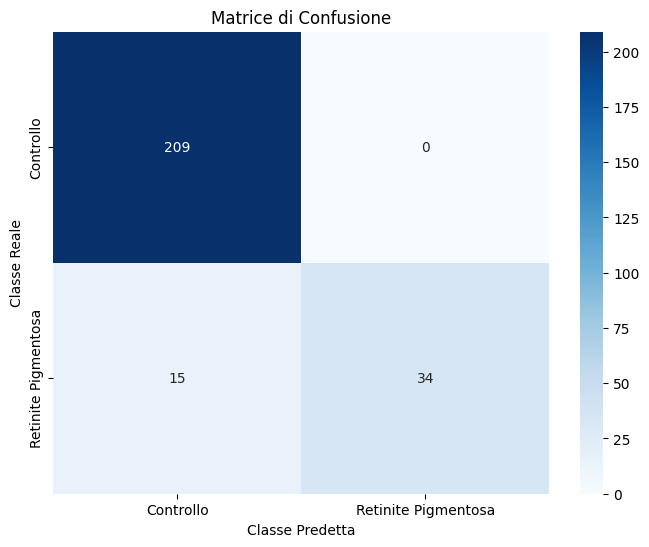

Classification Report:
                     precision    recall  f1-score   support

          Controllo       0.93      1.00      0.97       209
Retinite Pigmentosa       1.00      0.69      0.82        49

           accuracy                           0.94       258
          macro avg       0.97      0.85      0.89       258
       weighted avg       0.95      0.94      0.94       258



In [9]:
import torch
import sklearn.metrics as metrics
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Funzione per calcolare e visualizzare la matrice di confusione
def confusion_matrix(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = (outputs.squeeze() > 0.5).float()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = metrics.confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    # Visualizzazione della matrice di confusione
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Matrice di Confusione')
    plt.xlabel('Classe Predetta')
    plt.ylabel('Classe Reale')
    plt.show()

    # Report di classificazione
    print("Classification Report:")
    print(metrics.classification_report(all_labels, all_preds, target_names=class_names))

# Definisci le classi, modifica se necessario
class_names = ['Controllo', 'Retinite Pigmentosa']

# Calcolo e stampa della matrice di confusione
confusion_matrix(model, test_loader, class_names)


Utilizzare il modello

In [ ]:
from PIL import Image
import torchvision.transforms as T

# Funzione per fare una previsione su una singola immagine
def predict(model, image_path):
    model.eval()

    # Caricamento e trasformazione dell'immagine
    transform = T.Compose([
        T.Resize((150, 150)),
        T.ToTensor(),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Aggiungi una dimensione per batch
    image = image.to(device)

    # Predizione
    with torch.no_grad():  # Disabilita il calcolo dei gradienti
        output = model(image)  # Passa l'immagine nel modello per ottenere la previsione
        prediction = (output.squeeze() > 0.5).float()  # Applica una soglia di 0.5 per classificare


    print(f"Predizione: {'Retinite Pigmentosa' if prediction == 1 else 'Controllo'}")

# Esegui una previsione su un'immagine
img_path = '/content/drive/MyDrive/Night_Wolves/RPvsControl/data/test/retinite/Retinitis Pigmentosa73.jpg'
predict(model, img_path)

Predizione: Retinite Pigmentosa
